In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/HackTheRealty.zip

Archive:  /content/drive/My Drive/HackTheRealty.zip
  inflating: HackTheRealty/E/exposition_sample_submission.tsv  
  inflating: HackTheRealty/E/exposition_test.tsv  
  inflating: HackTheRealty/E/exposition_train.tsv  
  inflating: HackTheRealty/E/fields_exposition_train.md  
  inflating: HackTheRealty/P/fields_price_housebase.md  
  inflating: HackTheRealty/P/fields_price_train.md  
  inflating: HackTheRealty/P/price_housebase.tsv  
  inflating: HackTheRealty/P/price_sample_submission.tsv  
  inflating: HackTheRealty/P/price_test.tsv  
  inflating: HackTheRealty/P/price_train.tsv  
  inflating: HackTheRealty/quadkey.py  


In [ ]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from HackTheRealty.quadkey import quadkey2latlon

def clean_dfs(df, col="month"):
    latlon = df["city_quadkey"].apply(lambda x: quadkey2latlon(str(x)))
    df["lat"] = [l[0] for l in latlon]
    df["lon"] = [l[1] for l in latlon]
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d') #.apply(lambda x: x.year)
    df = df.sort_values("month")
    return df

prices = pd.read_csv("HackTheRealty/P/price_train.tsv", sep="\t")
prices = prices[[c for c in prices.columns if c != "offers_in_sites_ratio"]]
test = pd.read_csv("HackTheRealty/P/price_test.tsv", sep="\t")

prices = clean_dfs(prices)
test = clean_dfs(test)
predict_columns = ['apartment_ratio',
'unique_active_buildings_count',
'unique_active_building_series_count', 'rooms_offered_3_ratio',
'median_price_sqm', 'rooms_offered_4_more_ratio',
'rooms_offered_1_ratio', 'total_area_avg', 'studio_ratio',
'offer_count', 'rooms_offered_2_ratio', 'avg_price_sqm']

history = prices.groupby("month").mean()
for col in predict_columns:
    col_history = list(history[col].values)
    for month in sorted(test["month"].unique()):
        model = ARIMA(col_history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
        col_history.append(prediction)
        test.loc[test["month"] == month, col+"_mean"] = prediction
for c in predict_columns:
    prices[c +"_mean" ] = -1
    prices.loc[:, c +"_mean"] = prices.groupby("month").transform("mean")[c]
prices = prices.sort_values("month")
# переменные этого месяца предсказать по предыдущим 2 + за прошлый год
# + агрегированные тренды (но их тоже нужно предсказать? =())

In [ ]:
housebase = pd.read_csv("HackTheRealty/P/price_housebase.tsv", sep="\t")
grouped_housebase = housebase.groupby("city_quadkey")

prices = prices.merge(grouped_housebase.mean(), how="left", left_on="city_quadkey", suffixes=[None,"_bmean"], right_index=True)
prices = prices.merge(grouped_housebase.max(),  how="left", left_on="city_quadkey", suffixes=[None,"_bmax"], right_index=True)

test = test.merge(grouped_housebase.mean(), how="left", left_on="city_quadkey", suffixes=[None,"_bmean"], right_index=True)
test = test.merge(grouped_housebase.max(), how="left", left_on="city_quadkey", suffixes=[None,"_bmax"], right_index=True)

In [ ]:
dec_2017 = prices["month"].unique()[11]
prev_rows = []
j = 0
for row_i, row in prices.iterrows():
    print("\t", j, prices.shape[0], end="\r")
    j+=1
    if row["month"] <= dec_2017:
        continue
    sliced = prices[(prices["month"] < row["month"]) & (prices["city_quadkey"] == row["city_quadkey"])][-1:]
    if sliced.shape[0] == 0:
        prev_rows.append([-1] * len(predict_columns) + [-1])
        continue
    months_diff = [(row["month"] - sliced["month"].values[-1]) // (1000000000* 60 * 60 * 24 * 31)]
    sliced = sliced[[c for c in sliced.columns if c in predict_columns]]
    prev_rows.append(list(sliced.values[-1]) + months_diff)
for c in predict_columns:
    prices["prev_" + c] = -1
prices["prev_month"] = -1
prices.loc[prices["month"] > dec_2017, ["prev_" + c for c in predict_columns] + ["prev_month"]] = prev_rows

In [ ]:
prev_test_rows = []
j = 0
for row_i, row in test.iterrows():
    print("\t", j, test.shape[0], end="\r")
    j+=1
    # sliced = test[(test["month"] < row["month"]) & (test["city_quadkey"] == row["city_quadkey"])][-1:]
    sliced = prices[(prices["month"] < row["month"]) & (prices["city_quadkey"] == row["city_quadkey"])][-1:]
    if sliced.shape[0] == 0:
        prev_test_rows.append([-1] * len(predict_columns) + [-1])
        continue
        # if sliced.shape[0] == 0:
    months_diff = [(row["month"] - sliced["month"].values[-1]) // (1000000000* 60 * 60 * 24 * 31)]
    sliced = sliced[[c for c in sliced.columns if c in predict_columns]]
    prev_test_rows.append(list(sliced.values[-1]) + months_diff)
for c in predict_columns:
    test["prev_" + c] = -1
test["prev_month"] = -1
test.loc[:, ["prev_" + c for c in predict_columns] + ["prev_month"]] = prev_test_rows

In [ ]:
# prices = prices.fillna(-1)
# test = test.fillna(-1)

del_cols = {"city_quadkey", "unified_address", "building_id_bmax", "building_series_id_bmax",
            "unified_address", "prev_month", "building_type"}
cat_cols = {"building_type",}
def clean_cols(df):
    df = df[[c for c in df.columns if c not in del_cols]]
    # for col in cat_cols:
    #     df[col] = df[col].astype('category')
    return df

prices = clean_cols(prices)
test = clean_cols(test)

train = prices[[c for c in prices.columns
                if c in set(test.columns) or c == "avg_price_sqm" or c =="month"]]
jan_2018 = prices["month"].unique()[12]
jan_2019 = prices["month"].unique()[25]
train = train[(train["month"] >= jan_2018 ) & (train["month"] < jan_2019 )]
valid = prices[prices["month"] >= jan_2019]
train = train[[c for c in train.columns if c != "month"]]
valid = train[[c for c in train.columns if c != "month"]]
test = test[[c for c in test.columns if c != "month"]]
print(train.shape, valid.shape, test.shape)

(70092, 65) (70092, 65) (38030, 64)


(70092, 64) (70092,) (70092, 64) (70092,)
[1]	valid_0's rmse: 99197.1	valid_0's l2: 9.84007e+09
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 98217.7	valid_0's l2: 9.64672e+09
[3]	valid_0's rmse: 97248.2	valid_0's l2: 9.45722e+09
[4]	valid_0's rmse: 96288.5	valid_0's l2: 9.27148e+09
[5]	valid_0's rmse: 95338.5	valid_0's l2: 9.08943e+09
[6]	valid_0's rmse: 94398.1	valid_0's l2: 8.91101e+09
[7]	valid_0's rmse: 93467.3	valid_0's l2: 8.73614e+09
[8]	valid_0's rmse: 92545.9	valid_0's l2: 8.56475e+09
[9]	valid_0's rmse: 91633.9	valid_0's l2: 8.39677e+09
[10]	valid_0's rmse: 90731.1	valid_0's l2: 8.23212e+09
[11]	valid_0's rmse: 89837.4	valid_0's l2: 8.07076e+09
[12]	valid_0's rmse: 88952.8	valid_0's l2: 7.91261e+09
[13]	valid_0's rmse: 88077.1	valid_0's l2: 7.75757e+09
[14]	valid_0's rmse: 87210.4	valid_0's l2: 7.60565e+09
[15]	valid_0's rmse: 86352.3	valid_0's l2: 7.45672e+09
[16]	valid_0's rmse: 85503.1	valid_0's l2: 7.31078e+09
[17]	valid_0's rmse: 84662

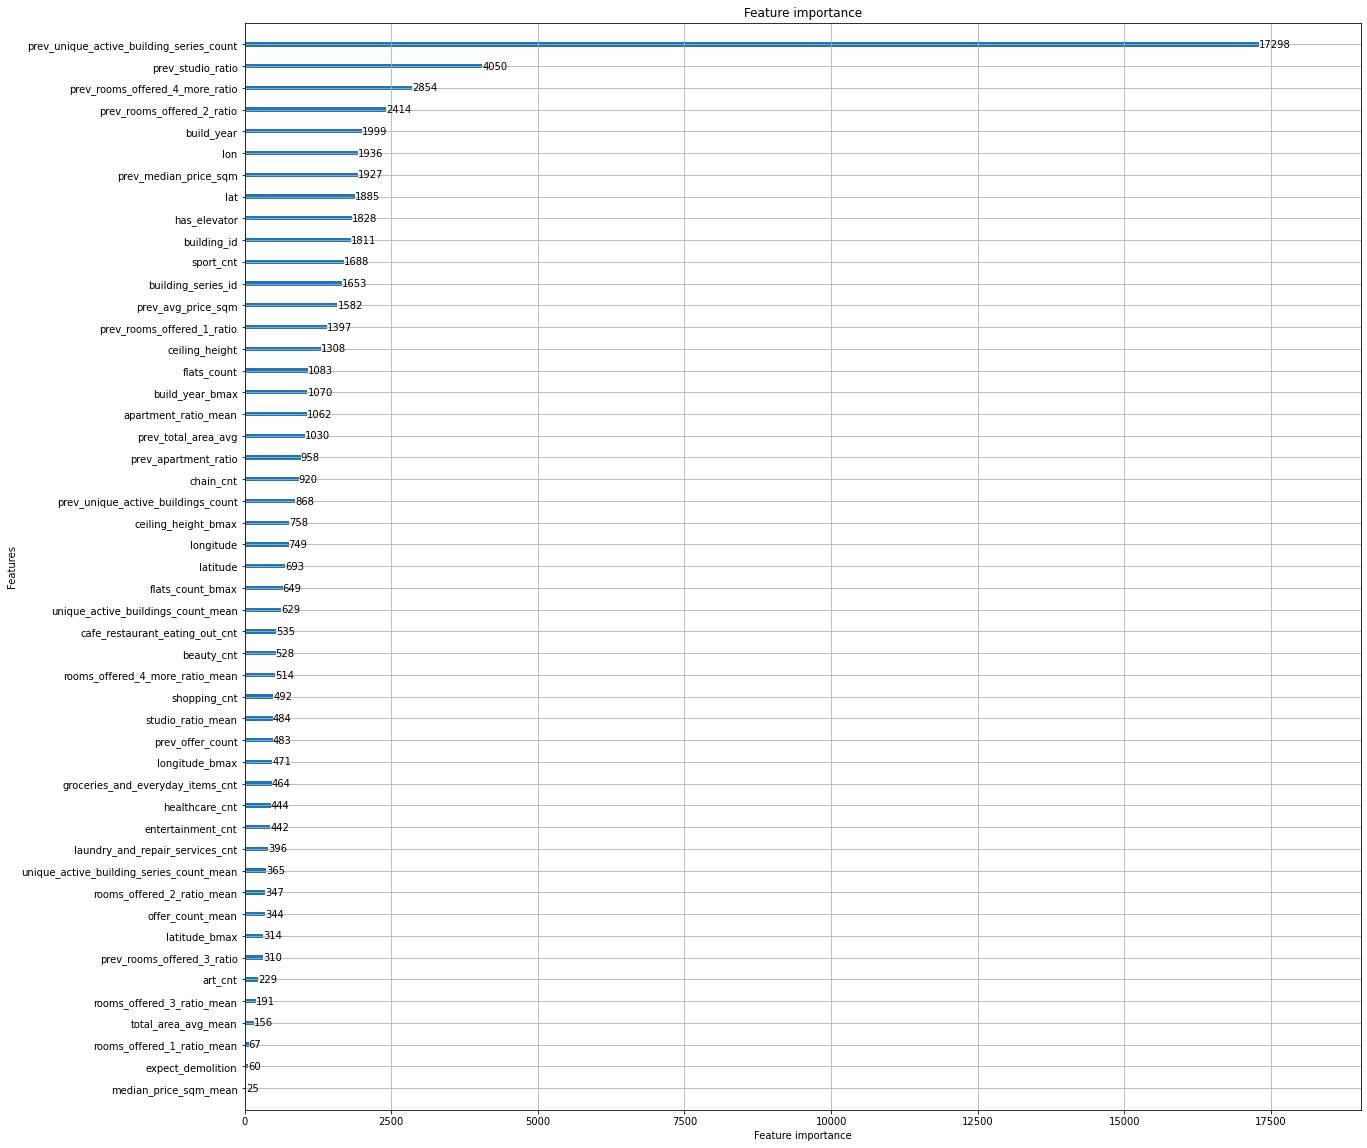

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def train_lgb(X_train, Y_train, X_valid, Y_valid):
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 8,
                            num_leaves = 240,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.01,
                            n_estimators = 500, )
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)
    %matplotlib inline
    ax = lgb.plot_importance(gbm)
    fig = ax.figure
    fig.set_size_inches(20, 20)
    score = rmse(Y_valid, gbm.predict(X_valid))
    print("lgb", score)
    return gbm, score



train_X, train_Y = train[[c for c in train.columns if c != "avg_price_sqm"]], train["avg_price_sqm"]
valid_X, valid_Y = valid[[c for c in valid.columns if c != "avg_price_sqm"]], valid["avg_price_sqm"]
print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)
train_Y = train_Y.astype(int)
valid_Y = valid_Y.astype(int)
gbm, score = train_lgb(train_X, train_Y, valid_X, valid_Y)

In [ ]:
test["preds"] = test_preds = gbm.predict(test)

In [ ]:
# rmse0 18522
# rmse1 9022

In [ ]:
submit = pd.read_csv("HackTheRealty/P/price_sample_submission.tsv", sep="\t")

In [ ]:
submit = submit.merge(test[["preds",]], left_index=True, right_index=True)
submit["avg_price_sqm"] = submit["preds"]

submit = submit[["month", "city_quadkey", "avg_price_sqm"]]

In [ ]:
submit.to_csv("p_predictions2.tsv", sep="\t", index=None)

In [ ]:
cp p_predictions.tsv /content/drive/My\ Drive/